In [1]:
import pandas as pd
import numpy as np
import sklearn
import sys
import os
import torch
import tqdm
sys.path.append('../')
sys.path.append('../../')
import numpy as np
import matplotlib.pyplot as plt
import ot
from fairws.metrics import exp_eval

plt.rcParams.update({'font.size': 14})

n_list = [10, 10**2, 10**3, 10**4, 10**5, 10**6, 10**7]

acc_baseline_list = []
f1_baseline_list = []
dp_baseline_list = []
eo_baseline_list = []

acc_list = []
f1_list = []
dp_list = []
eo_list = []
A_err_list = []
b_err_list = []
d = 2

# Group transformation - scaling & rotation + translation
mean = [ 0.0, 0.0]
cov = [[1.0, 0], [0, 1.0]]  # diagonal covariance
M = np.array([[2, 0], [0, 3]]) # Determine magnitude
theta = np.radians(30)
c, s = np.cos(theta), np.sin(theta)

# A = M@np.array(((c, -s), (s, c)))
A = np.array([[2, 1], [1, 2]])
b = np.array([-4, 5])

# Get true parameters from Y=AX+b --> X=A^{-1}(Y-b), true_param_A = A^{-1}, true_param_b = -A^{-1}b
A_inv = np.linalg.inv(A)
true_param_A = A_inv
true_param_b = -A_inv@b


for n in n_list:
    
    # Sampling - group 0
    X = np.random.multivariate_normal(mean, cov, size=n)
    
    # Sampling - group 1
    Y_ = np.random.multivariate_normal(mean, cov, size=n)
    Y = Y_@A + b
    
    # True labels
    X_c = X[:,0]>=0
    Y_c = Y_[:,0]>=0
    
    # Clean up data
    features = np.concatenate([X, Y])
    labels = np.concatenate([X_c, Y_c])
    groups = np.concatenate([np.array([0]*n), np.array([1]*n)])
    L = features[:, 0]>=0
    
    result_baseline = exp_eval(labels, L, groups)
    print(n, 'Before transport', result_baseline)
    acc_baseline_list.append(result_baseline['accuracy'])
    f1_baseline_list.append(result_baseline['fscore'])
    dp_baseline_list.append(result_baseline['demographic_parity_gap'])
    eo_baseline_list.append(result_baseline['equal_opportunity_gap'])
    
    # Optimal Transport: linear
    ot_map = ot.da.LinearTransport()
    ot_map.fit(Xs=Y, Xt=X)
    Y_transported = ot_map.transform(Y)

    Y_transported_c = Y_transported[:, 0]>=0
    L_pm = np.concatenate([X_c, Y_transported_c])
    
    # Evaluation...
    result = exp_eval(labels, L_pm, groups)
    print(n, 'After transport', result)
    
    # Save results...
    acc_list.append(result['accuracy'])
    f1_list.append(result['fscore'])
    dp_list.append(result['demographic_parity_gap'])
    eo_list.append(result['equal_opportunity_gap'])
    A_err_list.append(np.linalg.norm(ot_map.A_-true_param_A))
    b_err_list.append(np.linalg.norm(ot_map.B_-true_param_b))
    

2023-02-09 16:57:59.151242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 16:57:59.239972: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-09 16:57:59.690828: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-02-09 16:57:59.690925: W tensorflow/compiler/xla/stream_exe

10 Before transport {'accuracy': 0.55, 'fscore': 0.4, 'precision': 1.0, 'recall': 0.25, 'demographic_parity_gap': 0.30000001192092896, 'equal_opportunity_gap': 1.0}
10 After transport {'accuracy': 0.7, 'fscore': 0.6666666666666666, 'precision': 1.0, 'recall': 0.5, 'demographic_parity_gap': 0.0, 'equal_opportunity_gap': 0.6666666269302368}
100 Before transport {'accuracy': 0.785, 'fscore': 0.7189542483660131, 'precision': 1.0, 'recall': 0.5612244897959183, 'demographic_parity_gap': 0.44999998807907104, 'equal_opportunity_gap': 0.8958333134651184}
100 After transport {'accuracy': 0.985, 'fscore': 0.9849246231155778, 'precision': 0.9702970297029703, 'recall': 1.0, 'demographic_parity_gap': 0.009999990463256836, 'equal_opportunity_gap': 0.0}
1000 Before transport {'accuracy': 0.7785, 'fscore': 0.7132686084142394, 'precision': 1.0, 'recall': 0.5543259557344065, 'demographic_parity_gap': 0.4830000102519989, 'equal_opportunity_gap': 0.9287211894989014}
1000 After transport {'accuracy': 0.979,

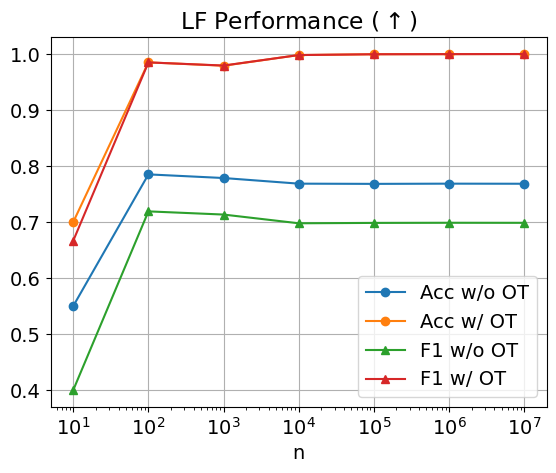

In [2]:
plt.plot(n_list, acc_baseline_list, 'o-', label='Acc w/o OT')
plt.plot(n_list, acc_list, 'o-', label='Acc w/ OT')
plt.plot(n_list, f1_baseline_list, '^-', label='F1 w/o OT')
plt.plot(n_list, f1_list, '^-', label='F1 w/ OT')

plt.xscale('log')
plt.xlabel('n')
plt.legend()
plt.grid()
plt.title('LF Performance ($\\uparrow$)')
plt.savefig('figures/synthetic_LF_performance.pdf', dpi=300)

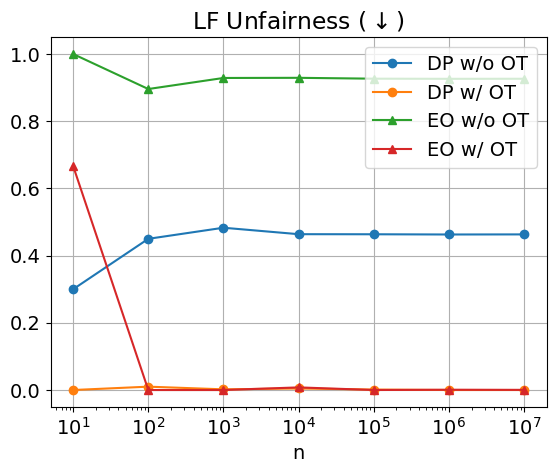

In [3]:
plt.plot(n_list, dp_baseline_list, 'o-', label='DP w/o OT')
plt.plot(n_list, dp_list, 'o-', label='DP w/ OT')
plt.plot(n_list, eo_baseline_list, '^-', label='EO w/o OT')
plt.plot(n_list, eo_list, '^-', label='EO w/ OT')

plt.xscale('log')
plt.xlabel('n')
plt.legend()
plt.grid()
plt.title('LF Unfairness ($\downarrow$)')
plt.savefig('figures/synthetic_LF_unfairness.pdf', dpi=300)

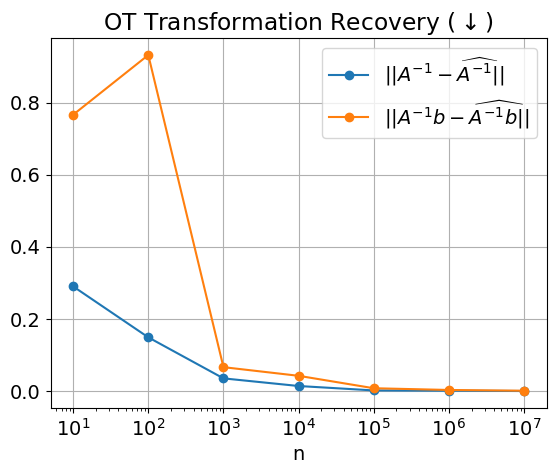

In [4]:
plt.plot(n_list, A_err_list, 'o-', label='$||A^{-1}-\widehat{A^{-1}}||$')
plt.plot(n_list, b_err_list, 'o-', label='$||A^{-1}b-\widehat{A^{-1}b}||$')

plt.xscale('log')
plt.xlabel('n')
plt.legend()
plt.grid()
plt.title('OT Transformation Recovery ($\downarrow$)')
plt.savefig('figures/synthetic_LF_recovery.pdf', dpi=300)